In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import tqdm
import wandb

from acai.autoencoders import AutoencoderBase
from acai.backbones import build_simple_encoder, build_simple_decoder
from acai.convolution_visualizer import ConvolutionVisualizer
from acai.data import make_line_image
from acai.image_utils import collage_images, torch2numpy_image, unravel_images, draw_images
from acai.wandb_logger import WandbLogger
from acai.utils import init_weights_kaiming_normal, fix_seeds

In [2]:
IMAGE_SIZE = 32
BATCHSIZE = 64

100%|██████████| 10/10 [00:00<00:00, 38164.73it/s]


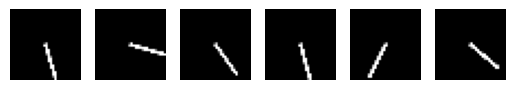

In [3]:
fix_seeds(0)
angles = np.random.uniform(-3, 3, size=10)
images = np.stack([make_line_image(angle) for angle in tqdm.tqdm(angles)])
images = images / 255
images = images.astype(np.float32)
draw_images(images[:6])

## Train pipeline

In [4]:
PI = 3.1416

def generate_batch(batchsize: int) -> torch.Tensor:
    angles = np.random.uniform(-PI, PI, size=batchsize)
    images = [make_line_image(angle) for angle in angles]
    batch = np.stack(images)
    batch = batch / 255
    batch = torch.FloatTensor(batch)
    batch = batch.view(batchsize, 1, IMAGE_SIZE, IMAGE_SIZE)
    return batch

In [5]:
from typing import Optional

class Trainer:
    N_EVAL_LOGGING_IMAGES = 3
    EVAL_EVERY = 500
    
    def __init__(
        self,
        autoencoder: AutoencoderBase,
        logger: Optional[WandbLogger] = None,
        device: torch.device = torch.device("cpu"),
    ):
        self.autoencoder = autoencoder
        self.logger = logger or WandbLogger('debug', 'acai_karpathy')
        self.device = device
        self.convolution_visualizer = ConvolutionVisualizer()
        
    def train(self, n_steps):
        eval_batch = generate_batch(batchsize=64).to(self.device)
        self.autoencoder = self.autoencoder.to(self.device)
        for step in range(n_steps):
            self.train_step()
            if step % self.EVAL_EVERY == 0:
                self.eval_step(eval_batch)
                # self.monitor_step()
            self.logger.commit()

    def _train_step(self) -> None:
        raise NotImplementedError()
    
    def eval_step(self, batch):
        self.autoencoder.eval()
        batch2 = generate_batch(BATCHSIZE).to(self.device)
        first_images = torch2numpy_image(batch[:self.N_EVAL_LOGGING_IMAGES])
        out = self.autoencoder(batch, batch2)
        loss = out['loss']
        reconstructed_first_images = torch2numpy_image(out['reconstructed_images'][:self.N_EVAL_LOGGING_IMAGES])
        self.logger.log_images(
            "images/ae/eval/reconstruction", 
            collage_images([first_images, reconstructed_first_images])
        )
        self.logger.log({"ae/test/loss": loss.detach().item()})
        
    def monitor_step(self):
        convolutions: dict[str, np.ndarray] = self.convolution_visualizer.extract_convolutions(self.autoencoder)
        for name, weights in convolutions.items():
            unravelled_images = unravel_images(weights, max_rows=8)
            weights_collage = collage_images(unravelled_images)
            self.logger.log_images(
                "images/ae/convolutions/" + name,
                weights_collage,
            )

## Train AE

In [6]:
class AutoencoderTrainer(Trainer):
    def __init__(
        self,
        autoencoder: AutoencoderBase,
        logger: Optional[WandbLogger] = None,
        device: torch.device = torch.device("cpu"),
    ):
        super().__init__(autoencoder, logger, device)
        self.compute_loss = torch.nn.MSELoss()

    def train_step(self):
        self.autoencoder.train()
        batch = generate_batch(BATCHSIZE).to(self.device)
        first_image = torch2numpy_image(batch[0])
        out = self.autoencoder(batch)
        loss = out['loss']
        reconstructed_first_image = torch2numpy_image(out['reconstructed_images'][0])
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.logger.log_images(
            "images/ae/train/first_image_in_batch", 
            collage_images([first_image, reconstructed_first_image])
        )
        self.logger.log({"ae/train/loss": loss.detach().item()})
    

In [7]:
from acai.autoencoders import AutoencoderDefault
# fix_seeds(42)

# logger = WandbLogger(run='aekn8bbs', project='acai_karpathy', log_images_every=100)
# encoder = build_simple_encoder(width_coef=1)
# decoder = build_simple_decoder(width_coef=1)
# autoencoder = AutoencoderDefault(encoder, decoder)
# autoencoder.apply(init_weights)

# trainer = Trainer(autoencoder, logger=logger, device=torch.device("cuda"))
# trainer.train(n_steps=260000)

# Train ACAI

In [8]:
from acai.autoencoders import AutoencoderBase
from typing import Any

class ACAI(AutoencoderBase):
    GAMMA = 0.2
    LAMBDA = 0.5 / 4
    
    def __init__(self, encoder, decoder, critic):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.critic = critic
        self.compute_loss = torch.nn.MSELoss()
        
    def forward(self, images: torch.Tensor, images4interpolation: torch.Tensor) -> dict[str, Any]:
        latent = self.encoder(images)
        latent4interpolation = self.encoder(images4interpolation)
        interpolated_latent, alphas = self._mix_latents(latent, latent4interpolation)
        reconstructed_images = self.decoder(latent)
        interpolated_images = self.decoder(interpolated_latent)
        predicted_alphas = torch.mean(self.critic(interpolated_images), [1, 2, 3])
        
        reconstruction_loss = self.compute_loss(reconstructed_images, images)
        interpolation_loss = self.LAMBDA * (predicted_alphas ** 2).mean(axis=0)
        loss = reconstruction_loss + interpolation_loss
        return {
            "loss": loss,
            "reconstruction_loss": reconstruction_loss,
            "interpolation_loss": interpolation_loss,
            "reconstructed_images": reconstructed_images,
            "reconstructed_interpolated_images": interpolated_images,
            "reconstructed_interpolated_alphas": predicted_alphas,
        }
    
    def _mix_latents(self, latent, latent4interpolation) -> tuple[torch.Tensor, torch.Tensor]:
        """
        :param latent: torch.Tensor of shape [BATCH_SIZE, CHANNELS, HEIGHT, WIDTH]
        :return: tuple of two tensors. 
            1. Mixed latents, torch.Tensor of shape [BATCH_SIZE, CHANNELS, HEGIHT, WIDTH]
            2. Alphas, torch.Tensor of shape [BATCH_SIZE, 1, 1, 1]
        """
        batch_size = latent.shape[0]
        alphas = 0.5 * torch.rand(batch_size).reshape(-1, 1, 1, 1).to(latent.device)
        interpolated_latent = alphas * latent + (1 - alphas) * latent4interpolation
        return interpolated_latent, alphas
    
    def forward_critic(self, images: torch.Tensor, images4interpolation: torch.Tensor) -> dict[str, Any]:
        with torch.no_grad():
            latent = self.encoder(images)
            latent4interpolation = self.encoder(images4interpolation)
            interpolated_latent, alphas = self._mix_latents(latent, latent4interpolation)
            reconstructed_images = self.decoder(latent)
            interpolated_images = self.decoder(interpolated_latent)
            regularization_images = self.GAMMA * images + (1 - self.GAMMA) * reconstructed_images
        predicted_alphas = torch.mean(self.critic(interpolated_images), [1, 2, 3])
        predicted_alphas_regularization = torch.mean(self.critic(regularization_images), [1, 2, 3])

        alpha_recovery_loss = torch.nn.functional.mse_loss(predicted_alphas, alphas.squeeze())
        regularization_loss = (predicted_alphas_regularization ** 2).mean(0)
        loss = alpha_recovery_loss + regularization_loss
        return {
            "loss": loss,
            "alpha_recovery_loss": alpha_recovery_loss,
            "regularization_loss": regularization_loss,
            "reconstructed_interpolated_images": interpolated_images,
            "reconstructed_images": reconstructed_images,
            "blended_non_interpolated_images": regularization_images,
        }

In [9]:
class ACAITrainer(Trainer):
    autoencoder: ACAI
    TRAIN_CRITIC_AFTER = 0
    
    def __init__(
        self,
        autoencoder: ACAI,
        logger: Optional[WandbLogger] = None,
        device: torch.device = torch.device("cpu"),
    ):
        super().__init__(autoencoder, logger, device)
        self.optimizer_ae = torch.optim.Adam([*autoencoder.encoder.parameters(), *autoencoder.decoder.parameters()], lr=3e-4)
        self.optimizer_critic = torch.optim.Adam(autoencoder.critic.parameters(), lr=3e-4)
        self._step_counter = 0
    
    def train_step(self):
        self.autoencoder.train()
        self._train_ae()
        if self.TRAIN_CRITIC_AFTER < self._step_counter:
            self._train_critic()
        self._step_counter += 1
    
    def _train_ae(self):
        # self.autoencoder.train()
        # self.autoencoder.critic.eval()
        batch1 = generate_batch(BATCHSIZE).to(self.device)
        batch2 = generate_batch(BATCHSIZE).to(self.device)
        first_image = torch2numpy_image(batch1[0])
        out = self.autoencoder(batch1, batch2)
        loss = out['loss']
        self.optimizer_ae.zero_grad()
        loss.backward()
        self.optimizer_ae.step()

        self.logger.log({"ae/train/loss": loss.detach().item()})
        self.logger.log({"ae/train/reconstruction_loss": out['reconstruction_loss'].detach().item()})
        self.logger.log({"ae/train/interpolation_loss": out['interpolation_loss'].detach().item()})
        self.logger.log_images(
            "images/ae/train/first_image_in_batch", 
            collage_images([first_image, torch2numpy_image(out['reconstructed_images'][0])])
        )
        self.logger.log_images(
            "images/ae/train/decoded_interpolation",
            torch2numpy_image(out["reconstructed_interpolated_images"][0]),
        )
        
    def _train_critic(self):
        # self.autoencoder.eval()
        # self.autoencoder.critic.train()
        batch1 = generate_batch(BATCHSIZE).to(self.device)
        batch2 = generate_batch(BATCHSIZE).to(self.device)
        first_image = torch2numpy_image(batch1[0])
        out = self.autoencoder.forward_critic(batch1, batch2)
        loss = out['loss']
        self.optimizer_critic.zero_grad()
        loss.backward()
        self.optimizer_critic.step()

        self.logger.log({"critic/train/loss": loss.detach().item()})
        self.logger.log({"critic/train/alpha_recovery_loss": out['alpha_recovery_loss'].detach().item()})
        self.logger.log({"critic/train/regularization_loss": out['regularization_loss'].detach().item()})
        self.logger.log_images(
            "images/critic/train/first_image_in_batch", 
            collage_images([first_image, torch2numpy_image(out['reconstructed_images'][0])])
        )
        self.logger.log_images(
            "images/critic/train/decoded_interpolation",
            torch2numpy_image(out["reconstructed_interpolated_images"][0]),
        )
        self.logger.log_images(
            "images/critic/train/blended_image",
            torch2numpy_image(out["blended_non_interpolated_images"][0]),
        )

In [ ]:
fix_seeds(42)

logger = WandbLogger(run='acaild4', project='acai_karpathy', log_images_every=100)
encoder = build_simple_encoder(width_coef=1)
decoder = build_simple_decoder(width_coef=1)
critic = build_simple_encoder(width_coef=1)
autoencoder = ACAI(encoder, decoder, critic)
autoencoder.apply(init_weights_kaiming_normal)

trainer = ACAITrainer(autoencoder, logger=logger, device=torch.device("cuda"))
trainer.train(n_steps=260000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: implausible_deniability. Use `wandb login --relogin` to force relogin


In [ ]:
def interpolate_encoder(encoder, decoder, idx=0):
    N_STEPS = 9
    images = generate_batch(2)

    encoder.eval()
    decoder.eval()
    image1_latent, image2_latent = (encoder(image.unsqueeze(0)) for image in images)
    interpolated_latents = [alpha*image1_latent + (1-alpha)*image2_latent for alpha in np.linspace(0.0, 1.0, N_STEPS)]
    interpolated_images = [decoder(latent).squeeze() for latent in interpolated_latents]

    fig, ax = plt.subplots(1, N_STEPS, figsize=(15, 5))
    for i in range(N_STEPS):
        ax[i].imshow(interpolated_images[i].detach().numpy(), cmap='gray')

In [ ]:
interpolate_encoder(autoencoder.encoder.cpu(), autoencoder.decoder.cpu())